# Using only gamma-cat flux points.

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

# Temporarily fixing environment variable for gamma-cat
import os
os.environ['GAMMA_CAT'] = os.path.join('C:/Users/Arjun/github/gamma-cat')

## The source

[HESS J1507-622](https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS_J1507m622_sed_0.png) (this picture is from the new HESS data, I won't be using it).

- gamma-sky.net: http://gamma-sky.net/#/cat/tev/77

- gamma-cat: source id 77

- AKA 3FGL J1506.6-6219 (3FGL) and 2FHL J1507.4-6213 (2FHL)

- unidentified source. 

- I want to fit a LogParabola spectral model to this source.


In [19]:
from gammapy.catalog import SourceCatalogGammaCat, SourceCatalogObjectGammaCat

cat = SourceCatalogGammaCat()
source = cat['HESS J1507-622']

data = source.flux_points.table

dnde_err = data['dnde'] * (data['dnde_errn'] / data['dnde'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)

data

e_ref,dnde,dnde_errp,dnde_errn,dnde_ul,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32,float32,float32
0.8609,2.29119e-12,8.95502e-13,8.70543e-13,nan,8.70543e-13
1.56151,6.98172e-13,2.30407e-13,2.20354e-13,nan,2.20354e-13
2.76375,1.69062e-13,7.18838e-14,6.7587e-14,nan,6.7587e-14
4.8916,7.72925e-14,2.60749e-14,2.40132e-14,nan,2.40132e-14
9.98858,1.03253e-14,5.64195e-15,5.06315e-15,nan,5.06315e-15
27.0403,7.44987e-16,7.25999e-16,5.72089e-16,nan,5.72089e-16


In [62]:
p = source.spectral_model.parameters
print(p)

ParameterList
Parameter(name='index', value=2.490000009536743, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=3.100000074349185e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  3.24000026e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.39999978e-25   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]


## Plotting data and model

We're plotting a LogParabola model.

<Container object of 3 artists>

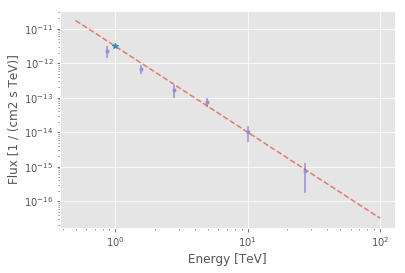

In [107]:
# defining units and energy range
energy_range = [0.5, 100] * u.TeV
opts = dict(energy_unit='TeV', flux_unit='cm-2 s-1 TeV-1', energy_range=energy_range)

source.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

plt.plot(p['reference'].value, p['amplitude'].value, '*')

plt.errorbar(x=data['e_ref'],
             y=data['dnde'],
             yerr=data['dnde_err'],
             fmt='.')


## Defining chi2 function

In [78]:
def chi2(amplitude, index):
    
    dnde_model = source.spectral_model.evaluate(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        reference=p['reference'].value
    )
    
    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

## Maximum likelihood fit for our model

In [79]:
from iminuit import Minuit

pars = dict(amplitude=p['amplitude'].value, index=p['index'].value)

minuit = Minuit(chi2, **pars)

minuit.print_initial_param()
print("^ Initial parameters")

minuit.migrad() # Performs the minimization
print("^ Optimized parameters for best-fit model")

C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: errordef is not given. Default to 1.
  """
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
  """
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
  """


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,3.1e-12,1,0,0,,,
2,index,2.49,1,0,0,,,


^ Initial parameters


FCN = 1.708320140838623 
 TOTAL NCALL = 80 
 NCALLS = 80 
 
 
 EDM = 3.327811441405095e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.84517e-12,3.23998e-13,0,0,,,
2,index,2.26064,0.0627938,0,0,,,


^ Optimized parameters for best-fit model


## Final plot

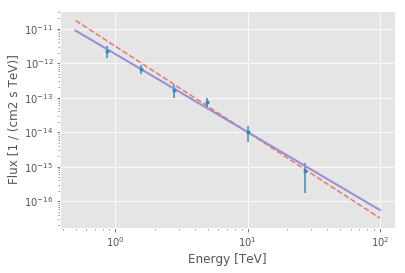

In [110]:
source.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=energy_range[0],
    emax=energy_range[1],
    nbins=100,
)


flux = source.spectral_model.evaluate(
    energy=energy.to('TeV').value,
    amplitude = minuit.values['amplitude'],
    index = minuit.values['index'],
    reference=p['reference'].value,
)
plt.plot(energy, flux, linewidth=2)